# Incorporating uncertainties in the search phase of MORDM

This notebook demonstrates conducting MORDM's search phase under multiple scenarios. These scenarios are selected based on maximal diversity and policy relevance. 

Below:

Step 1: Problem Formulation/Case Study : lake model with closed loop control

Step 2: Scenario selection when anthropogenic pollution is zero

Step 3: Multi-scenario search to generate candidate solutions

Step 4: Evaluating the robustness of solutions generated for different scenarios


# Helper functions

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  

fs = 16

def setup_parallel_plot(labels, maxima, minima, new_labels):
    #labels is a list, minima and maxima pd series
    nr_columns = len(labels)
    fig = plt.figure()
    axes = []
    
    # we need one axes less than the shape
    for i, label in enumerate(labels[:-1]):
        i += 1
        ax = fig.add_subplot(1,nr_columns-1,i,  ylim=(-0.1,1.1))
        axes.append(ax)
        ax.set_xlim([i,i+1])
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.xaxis.set_ticklabels([new_labels[i-1]]) #, rotation=90)
        ax.xaxis.set_tick_params(bottom=False, top=False)
        
        #let's put our own tick labels
        ax.yaxis.set_ticks([])
        ax.text(i, 1.01, "{:.2f}".format(maxima[label]), va="bottom", ha="center", fontsize=fs)
        ax.text(i, -0.01,"{:.2f}".format(minima[label]), va="top", ha="center", fontsize=fs)
        
        ax.spines['left'].set_bounds(0, 1)
        ax.spines['right'].set_bounds(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    
    # for the last axis, we need 2 ticks (also for the right hand side
    ax.spines['right'].set_bounds(0, 1)
    ax.xaxis.set_major_locator(ticker.FixedLocator([i, i+1]))
    ax.xaxis.set_ticklabels(new_labels[i-1:i+1], fontsize=fs)
    ax.text(i+1, 1.01, "{:.2f}".format(maxima[labels[-1]]), va="bottom", ha="center", fontsize=fs)
    ax.text(i+1, -0.01,"{:.2f}".format(minima[labels[-1]]), va="top", ha="center", fontsize=fs)
    
    # add the tick labels to the rightmost spine
    for tick in ax.yaxis.get_major_ticks():
        tick.label2On=True
    
    # stack the subplots together
    plt.subplots_adjust(wspace=0)
    
    return axes


def normalize(data, minima, maxima):
    #takes pandas dataframe as data, and series as minima and maxima
    d = maxima - minima
    d[d==0] = 1
    norm_data = data.copy()
    for col in data.columns:
        norm_data[col] = (data[col]-minima[col])/d[col]
    #norm_data = data/d - minima/d
    return norm_data




In [2]:
def change_fontsize(fig, fs=14):
    '''Change fontsize of figure items to specified size'''
    # TODO:: add legend and general text items

    for ax in fig.axes:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                      ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fs)
        
        try:
            parasites = ax.parasites
        except AttributeError:
            pass
        else:
            for parisite in parasites:
                for axis in parisite.axis.values():
                    axis.major_ticklabels.set_fontsize(fs)
                    axis.label.set_fontsize(fs)

            for axis in ax.axis.values():
                axis.major_ticklabels.set_fontsize(fs)
                axis.label.set_fontsize(fs)
        
        if ax.legend_ != None:
            for entry in ax.legend_.get_texts():
                entry.set_fontsize(fs)


In [3]:
def save_fig(fig, dir, name):
    '''save a high res and a low res version of the figure in the specified
    directory, using the label i.
    
    Parameters
    ----------
    fig : a Figure instance
    dir : str
          the directory where figures are to be saved
    name : str
    
    '''
    
    fig.savefig('{}/fig{}_lowres.png'.format(dir, name), dpi=75, 
                bbox_inches='tight', format='png')
    fig.savefig('{}/fig{}_highres.png'.format(dir, name), dpi=300, 
                bbox_inches='tight', format='png')  

## Step 1: Problem formulation
### The lake model with closed loop control

The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication. 

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$. 
There are four outcomes of interest. The first is the average concentration of phosphor in the lake. 

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

where \left\vert{T}\right\vert is the cardinality of the set of points in time. 
The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate. 

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

In the **open loop control**, the rate of anthropogenic pollution $a_t$ is the decision variable and is somewhere between 0, and 0.1. So $a_t \in [0,0.1]$. In the **closed loop control**, $a_t$ is dependent on $X_t$, i.e. the rate of anthropogenic pollutions is lowered if the pollution level is approaching a critical threshold. Here, we use "cubic radial basis functions" following *Quinn et al. 2016* and formulate $a_t$ as follows:

\begin{equation}
    a_{t} =  min\Bigg(max\bigg(\sum\limits_{j=1}^{n} w_{j}\left\vert{\frac{X_{t,i}-c_{j}}{r_{j}}}\right\vert, 0.01\bigg), 0.1\Bigg) \\
    s.t. \\
    -2 \leq c_{j} \leq 2 \\
    0 \leq r_{j} \leq 2 \\ 
    0 \leq w_{j} \leq 1 \\
    \sum\limits_{j=1}^{n} w_{j} = 1
\end{equation}




The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |



In [4]:
import numpy as np
#THE FUNCTION FOR ANTHROPOGENIC POLLUTION FOR CLOSED LOOP CONTROL
def a_t(X, #x is a scalar, pollution at time t
        c=[],
        r=[],
        w=[],
        n=2):

    a = sum([w[j]*(abs((X-c[j])/r[j]))**3 for j in range(n)])
    return min(max(a, 0.01), 0.1)
   

In [5]:
def lake_problem_closedloop(
         b = 0.42,          # decay rate for P in lake (0.42 = irreversible)
         q = 2.0,           # recycling exponent
         mean = 0.02,       # mean of natural inflows
         stdev = 0.001,     # future utility discount rate
         delta = 0.98,      # standard deviation of natural inflows
         
         alpha = 0.4,       # utility from pollution
         nsamples = 100,    # Monte Carlo sampling of natural inflows
         timehorizon = 100, # simulation time
         **kwargs):         
    '''
    in the closed loop version, utility and inertia are included in the Monte Carlo simulations, too,
    since they are now dependent on a[t].
    '''
    c1 = kwargs['c1']
    c2 = kwargs['c2']
    r1 = kwargs['r1']
    r2 = kwargs['r2']
    w1 = kwargs['w1']
    w2 = 1 - w1

    
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    nvars = int(timehorizon)
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = np.zeros((nvars,))

    reliability = 0.0
    utility = 0.0
    inertia = 0.0

    for _ in range(nsamples):
        X[0] = 0.0
        decisions[0] = 0.0
        natural_inflows = np.random.lognormal(
                math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
                math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
                size = nvars)
  
        for t in range(1,nvars):
            decisions[t] = a_t(X[t-1],c=[c1,c2], r=[r1,r2], w=[w1,w2])
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) +\
                    decisions[t-1] +\
                    natural_inflows[t-1]
            average_daily_P[t] += X[t]/float(nsamples)
        
        reliability += np.sum(X < Pcrit)/float(nsamples*nvars)
        utility += (np.sum(alpha*decisions*np.power(delta,np.arange(nvars)))) / float(nsamples)
        inertia += (np.sum(np.absolute(np.diff(decisions)) > 0.02)/float(nvars-1)) / float(nsamples)

      
    max_P = np.max(average_daily_P)
    return max_P, utility, inertia, reliability

## Step 2: Scenario selection

### Step 2.1: Specifying the model and generating N=1000 scenarios


In [6]:
import numpy as np
from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem_closedloop)
lake_model.time_horizon = 100
#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter("c1", -2, 2),
                     RealParameter("c2", -2, 2),
                     RealParameter("r1", 0, 2), #[0,2]
                     RealParameter("r2", 0, 2), #
                     RealParameter("w1", 0, 1)
                     ]

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 100),
                        Constant('timehorizon', lake_model.time_horizon),
                       ]


C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:22: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


No that to generate scenarios with no anthropogenic pollution, the parameters *w1* and *w2* within the *lake_problem* function are set to 0. 

In [7]:
import os

from ema_workbench import (perform_experiments, ema_logging, save_results, 
                           load_results)
from ema_workbench.em_framework import samplers

# turn on logging
ema_logging.log_to_stderr(ema_logging.INFO)

# perform experiments
nr_experiments = 1000
nr_policies = 1
fn = './data/{}_experiments_closedloop_noApollution_correctedInertia.tar.gz'.format(nr_experiments)

try:
    # why regenerate the data?
    results = load_results(fn)
except IOError:
    results = perform_experiments(lake_model, scenarios=nr_experiments)
    save_results(results, fn)


[MainProcess/INFO] results loaded succesfully from H:\MyDocuments\Notebooks\Lake_model-MORDM\Sibel\MORDM_paper\data\1000_experiments_closedloop_noApollution_correctedInertia.tar.gz


### Select 4 scenarios randomly, for comparison

In [10]:
import random
random.sample(range(0, 999), 4)

[317, 208, 22, 304]

The scenarios with indices 22, 208, 304 and 317 will be used in comparison to the scenarios selected for their policy-relevance and diversity.

### Step 2.2: Select policy relevant scenarios based on the exploration results:
        - max_P >= median(~ 5)
        - reliability <= median (~0.5)
        - inertia <= median (~1)
        - utility <= median (~0.15)



In [8]:
experiments, outcomes = results
oois = sorted(outcomes.keys())

In [6]:
indices = []
for ooi in oois:
    if ooi in ['max_P', 'inertia']:
        a = outcomes[ooi] >= np.median(outcomes[ooi])     
    else: 
        a = outcomes[ooi] <= np.median(outcomes[ooi])
    indices.append(a)
indices = np.swapaxes(indices, 0, 1)
logical_index = np.array([index.all() for index in indices])
newExperiments = experiments[logical_index]
newOutcomes = {}
for ooi in oois:
    newOutcomes[ooi] = outcomes[ooi][logical_index]
newResults = newExperiments, newOutcomes

In [7]:
print(len(newOutcomes['max_P']))

211


In [8]:
new_fn = './data/211_experiments_closedloop_noApollution_inertia.tar.gz'
save_results(newResults, new_fn)

[MainProcess/INFO] results saved successfully to ./data/211_experiments_closedloop_noApollution_inertia.tar.gz


### Step 2.3: Find the set of  maximally diverse K=4 scenarios  in the subset of such policy relevant scenarios

### - Exhaustive search -



In [21]:
from scipy.spatial.distance import pdist 
def calculate_distance(data, oois, scenarios, distance):
    '''data is the outcomes of exploration results,
    scenarios is a list of scenario indices (decision variables), 
    oois is a list of variable names,
    distance is to choose the distance metric. options:
            bray-curtis, canberra, chebyshev, cityblock (manhattan), correlation, 
            cosine, euclidean, mahalanobis, minkowski, seuclidean,
            sqeuclidean, wminkowski
    returns a list of distance values
    '''
    #make a matrix of the data n_scenarios x oois
    scenario_data = np.zeros((len(scenarios), len(oois)))
    for i, s in enumerate(scenarios):
        for j, ooi in enumerate(oois):
            scenario_data[i][j] = data[ooi][s]
                
    distances = pdist(scenario_data, distance)
    return distances

In [22]:
def evaluate_diversity_single(x, data, oois, weight, distance):
    '''
    takes the outcomes and selected scenario set (decision variables), 
    returns a single 'diversity' value for the scenario set.
    outcomes : outcomes dictionary of the scenario ensemble
    decision vars : indices of the scenario set
    weight : weight given to the mean in the diversity metric. If 0, only minimum; if 1, only mean
    '''
    distances = calculate_distance(data, oois, x, distance)
    minimum = np.min(distances)
    mean = np.mean(distances)
    diversity = (1-weight)*minimum + weight*mean
    
    return diversity

In [23]:
#EXHAUSTIVE SEARCH
import itertools

def find_maxdiverse_scenarios(outcomes, set_size, weight, distance):
    oois = list(outcomes.keys())
    n_scen = len(outcomes[oois[0]])
    indices = range(n_scen)
    diversity = 0.0
    solutions = []
    for sc_set in itertools.combinations(indices, set_size):
        temp_div = evaluate_diversity_single(list(sc_set), outcomes, oois, weight, distance)
        if temp_div > diversity:
            diversity = temp_div
            solutions = []
            solutions.append(sc_set)
        elif temp_div == diversity:
            solutions.append(sc_set)
    return diversity, solutions

Scenario selection is run locally using the multiprocessing library. See the file **ScenarioSelection.py** for actual execution of the scenario selection algorithm.

The results for different weights and distance metrics are saved in a csv file. Below, the results are taken from this file and visualized.

In [15]:
import pandas as pd
df_selected = pd.read_excel('./data/Results_Scenario_selection_10_normalized.xlsx')
df_selected

metric  weight                                     selected  diversity
0  euclidean    0.00  [(23, 153, 160, 207), (153, 160, 197, 207)]   0.997395
1  euclidean    0.25                       [(153, 160, 197, 207)]   1.041078
2  euclidean    0.50                       [(153, 160, 197, 207)]   1.084761
3  euclidean    0.75                       [(153, 160, 197, 207)]   1.128445
4  euclidean    1.00                        [(74, 160, 179, 197)]   1.228389
5  cityblock    0.00                        [(65, 153, 197, 207)]   1.486630
6  cityblock    0.25                       [(153, 160, 197, 207)]   1.551637
7  cityblock    0.50                       [(153, 160, 197, 207)]   1.630188
8  cityblock    0.75                       [(153, 160, 197, 207)]   1.708739
9  cityblock    1.00                        [(74, 160, 179, 197)]   1.861619

In [16]:
import copy
#0 : non policy-relevant scenarios
#1 : policy-relevant scenarios
#2 : SELECTED

sel_column = logical_index.astype(int)
selected = [153, 160, 197, 207] #========SELECTED=================
count = 0
for index, i in enumerate(sel_column):
    if i:
        if count in selected:
            sel_column[index] = 2
        count +=1

print(len(sel_column))

1000


In [12]:
data = copy.copy(outcomes)
data['selected'] = sel_column
data = pd.DataFrame(data)

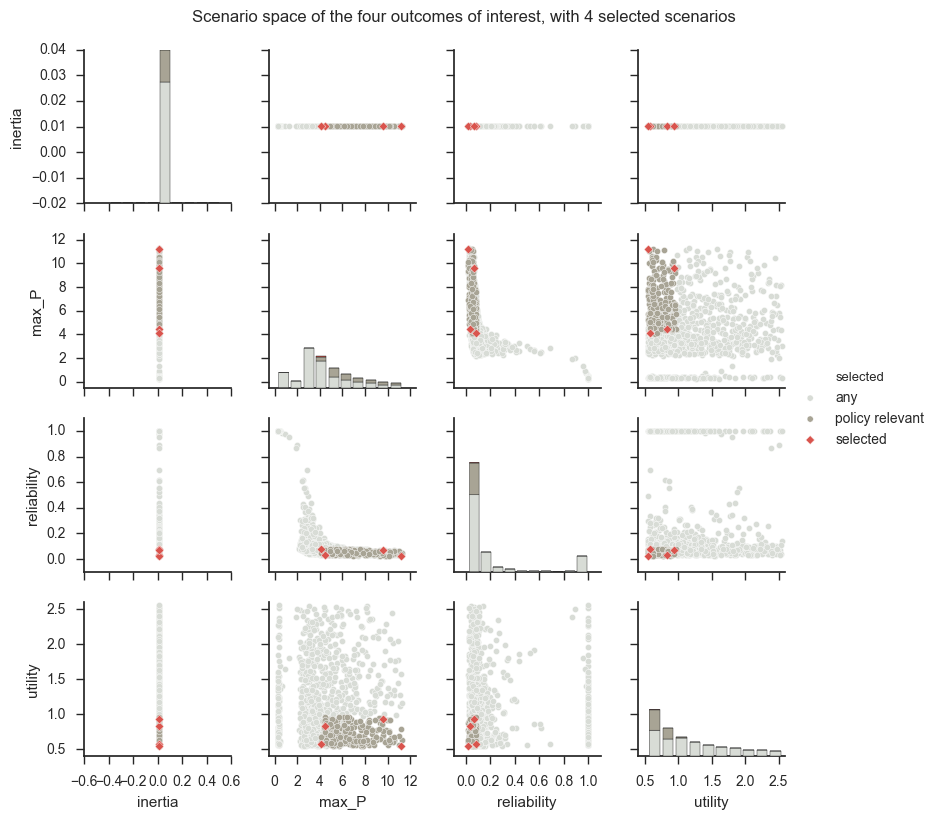

In [21]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)    
sns.axes_style('white')
colors = ["light grey", "greyish", "pale red"]

for entry, name in zip(np.unique(sel_column), ['any', 'policy relevant', 'selected']):
    data.replace(entry, name, inplace=True)
g = sns.pairplot(data, hue='selected', size=2, markers = ['o', 'o', 'D'],
             palette=sns.xkcd_palette(colors), vars=oois)
plt.suptitle("Scenario space of the four outcomes of interest, with 4 selected scenarios", y=1.02)
for i in range(4):
    g.axes[i][1].set_xlim(-0.5, 12.5) #max_p
    g.axes[i][2].set_xlim(-0.1, 1.1) #reliability
    g.axes[i][3].set_xlim(0.4, 2.6) #utility
    g.axes[3][i].set_ylim(0.4, 2.6) #utility
    g.axes[2][i].set_ylim(-0.1, 1.1) #relaibility
    g.axes[1][i].set_ylim(-0.5, 12.5)
g.savefig('./figs/mordm/scatter plot 4 selected of 1000 scenarios_v3.png', dpi=600)
plt.show()



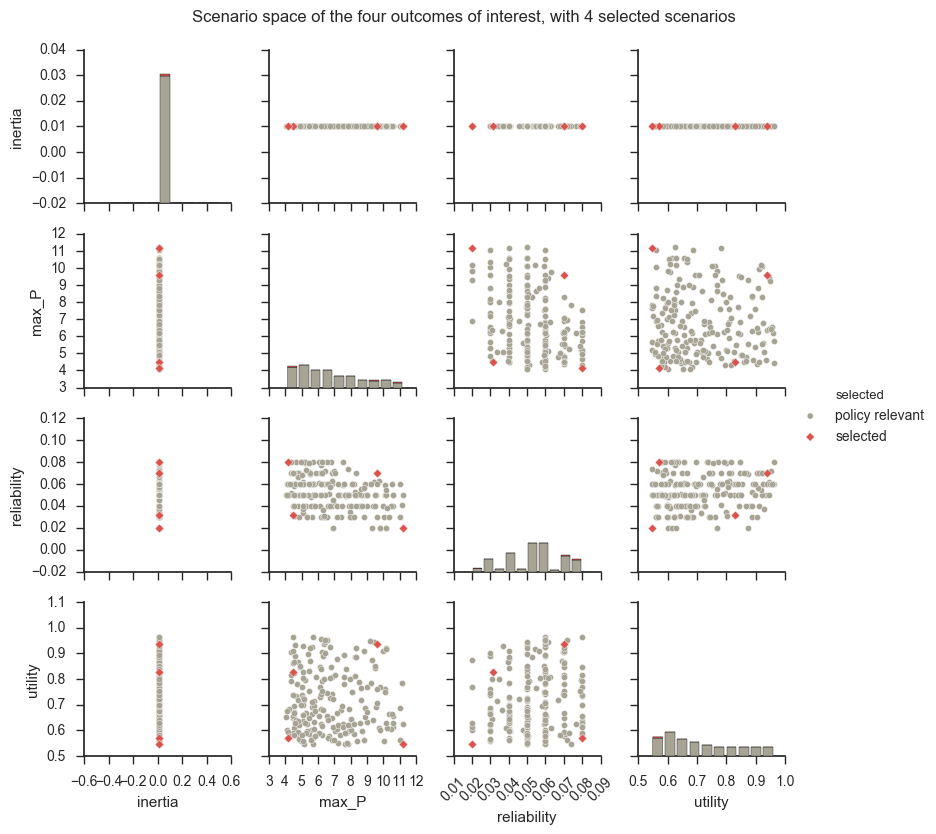

In [131]:
#only policy relevant
n_scen = len(newExperiments)
sel_column2 = np.zeros(n_scen)
for index in selected:
    sel_column2[index] = 1 
data2 = copy.copy(newOutcomes)
data2['selected'] = sel_column2
data2 = pd.DataFrame(data2)

colors = ["greyish", "pale red"]
sns.set(style="ticks", color_codes=True)    
sns.axes_style('white')

for entry, name in zip(np.unique(sel_column), ['policy relevant', 'selected']):
    data2.replace(entry, name, inplace=True)
g = sns.pairplot(data2, hue='selected', size=2,
             palette=sns.xkcd_palette(colors), vars=oois, markers=['o', 'D'])

# size = [40, 100]
# g = sns.PairGrid(data2, hue='selected', vars=oois, palette=sns.xkcd_palette(colors))
# g.map(plt.scatter,  s=size)

plt.suptitle("Scenario space of the four outcomes of interest, with 4 selected scenarios", y=1.02)
#save_fig(fig, dir = './figs/mordm', name="scatter plot 4 selected of 211 scenarios(closedloop) normalized")
g.axes[3][2].set_xticklabels([0.01, .02, .03, .04, .05, .06, .07, .08, .09, .1], rotation=45, fontsize=10)

g.savefig('./figs/mordm/scatter plot 4 selected of 211 scenarios_v2.png', dpi=600)
plt.show()

#### Plot the selected four scenarios

In [16]:
import seaborn as sns
flatui = ["#34495e", "#9b59b6", "#3498db", "#e74c3c", "#2ecc71"]
colors = sns.color_palette("Set2", 4)
sns.palplot(colors)

C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\importlib\_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [21]:
import pandas as pd
# ===parallel plot of selected scenarios ===
def parallel_plot_selected(outcomes, scenarios, title, t=1):
    
    oois = sorted(list(outcomes.keys()))

    df_outcomes = pd.DataFrame.from_dict(outcomes)

    minima = np.min(df_outcomes, axis=0)
    maxima = np.max(df_outcomes, axis=0)
    axes = setup_parallel_plot(oois, maxima, minima, oois)
    normed_data = normalize(df_outcomes, minima, maxima)
    normed_data = normed_data.sort_index(axis=1) #re-ordering the columns of the df to align the grid with the df
    fig = plt.gcf()
    
    #colors = ['indianred', 'royalblue', 'forestgreen', 'darkmagenta']
    labels = []
    some_identifiers = []
    labels = []
    some_identifiers = []
    for j in range(df_outcomes.shape[1]-1):
            ax = axes[j]
            y = normed_data.ix[:, j:j+2]
            x = np.tile([j+1,j+2], (y.shape[0], 1))
            ax.plot(x.T, y.T, color='grey', linewidth=0.5)
            for i, s in enumerate(scenarios):
                y_selected = normed_data.ix[s, j:j+2]
                ax.plot(x.T, y_selected.T, color=colors[i], lw=2)
                if j == 0:
                    labels.append("Scenario {}".format(s))
                    artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[i], facecolor=colors[i])
                    some_identifiers.append(artist)

                     
    plt.legend(some_identifiers, labels, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=16)

    change_fontsize(fig, 16)
    fig.suptitle("Randomly selected 4 scenarios", fontsize=20)
    save_fig(fig, dir = './figs/mordm', name=title)
    plt.show()  

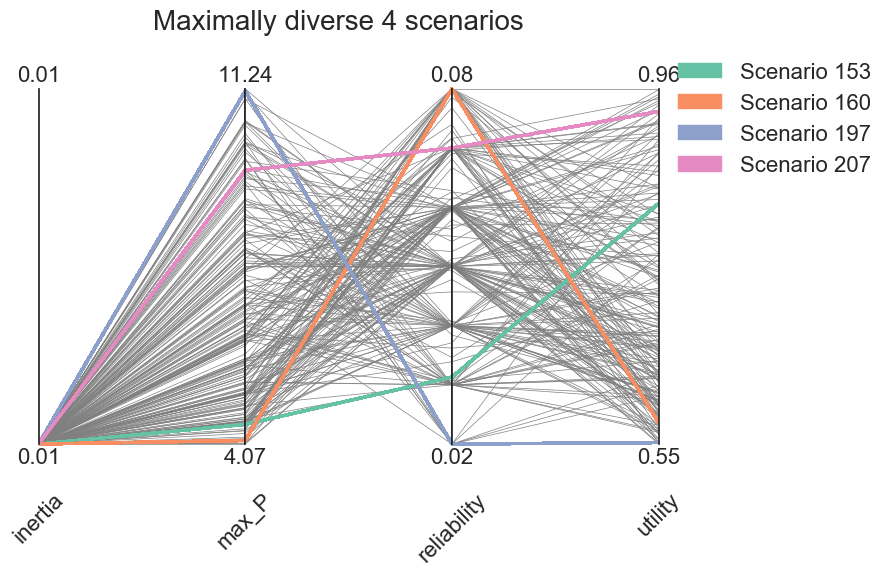

In [39]:
import seaborn as sns
sns.set_style("white")
parallel_plot_selected(newOutcomes, selected, "Selected scenarios in 211_v2")

C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


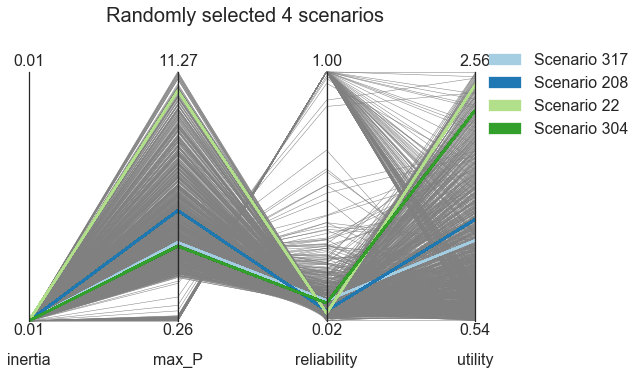

In [24]:
random_selected = [317, 208, 22, 304]
import seaborn as sns
sns.set_style("white")
colors = sns.color_palette("Paired", 4)
parallel_plot_selected(outcomes, random_selected, "Random_selected.png")

In [39]:
import seaborn as sns
sns.set(style="ticks", color_codes=True)    
sns.set_style('white', {'axes.edgecolor':'lightgrey'})

def parallel_plot_selected_annotated(data, scenarios, title, t=1):
    #data is newResults, tuple of experiments and outcomes
    experiments, outcomes = data
    labels = ['b', 'q', 'delta', 'mean', 'stdev'] + sorted(list(outcomes.keys()))
    

    df_outcomes = pd.DataFrame.from_dict(outcomes)
    df_outcomes = df_outcomes.sort_index(axis=1)
    df_experiments = pd.DataFrame(experiments)
    df_experiments = df_experiments[['b', 'q', 'delta', 'mean', 'stdev']]
    
    df = pd.concat([df_experiments, df_outcomes], axis=1, join_axes=[df_outcomes.index])

    
    minima = np.min(df, axis=0)
    maxima = np.max(df, axis=0)
    axes = setup_parallel_plot(labels, maxima, minima)
    normed_data = normalize(df, minima, maxima)
    #normed_data = normed_data.sort_index(axis=1) #re-ordering the columns of the df to align the grid with the df
    fig = plt.gcf()
    
    #colors = ['indianred', 'royalblue', 'forestgreen', 'darkmagenta']
    leg_labels = []
    some_identifiers = []
    for j in range(len(labels)-1):
        ax = axes[j]
        y = normed_data.ix[:, j:j+2]
        x = np.tile([j+1,j+2], (y.shape[0], 1))
        ax.plot(x.T, y.T, color='grey', linewidth=0.3)
        for i, s in enumerate(scenarios):
            y_selected = normed_data.ix[s, j:j+2]
            ax.plot(x.T, y_selected.T, color=colors[i], lw=3)
            if j == 0:
                leg_labels.append("Scenario {}".format(s))
                artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[i], facecolor=colors[i])
                some_identifiers.append(artist)
            #plot lines below the axes
            if j < 4:
                ax.axhline(y=-0.4,xmin=0,xmax=1,c="black",linewidth=1,zorder=0, clip_on=False)
            elif j > 4:
                ax.axhline(y=-0.4,xmin=-0.5,xmax=1,c="black",linewidth=1,zorder=0, clip_on=False)
    
    plt.legend(some_identifiers, leg_labels, loc=2, bbox_to_anchor=(1.05, 0.9), borderaxespad=0., fontsize=13)
    plt.text(2.2, -0.45, "Deep uncertainties", fontsize=13)
    plt.text(6.2, -0.45, "Outcome indicators", fontsize=13)  
                     
    #plt.legend(some_identifiers, leg_labels, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=16)

    change_fontsize(fig, 16)
    fig.suptitle("Maximally diverse 4 scenarios", fontsize=20)
    save_fig(fig, dir = './figs/mordm', name=title)
    plt.show()  

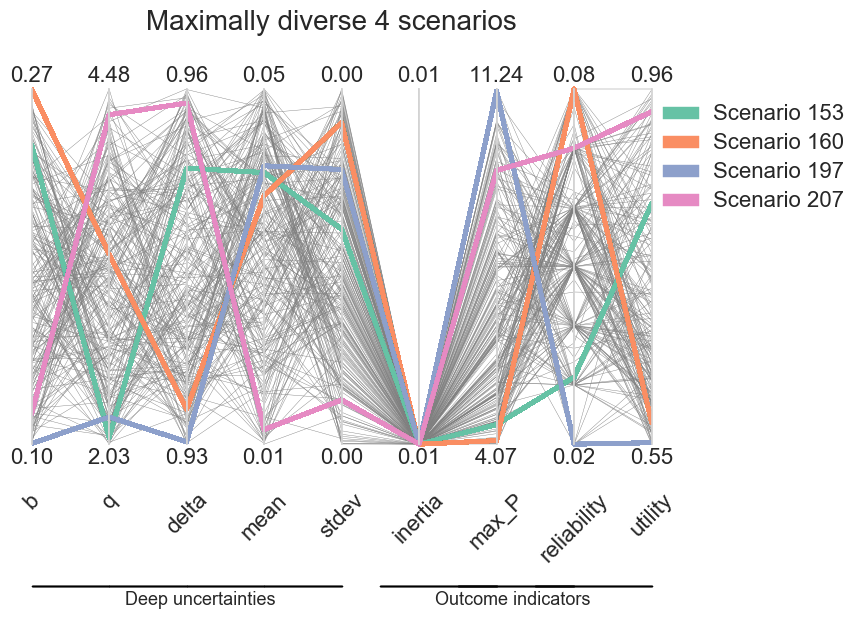

In [46]:
parallel_plot_selected_annotated(newResults, selected, "Selected scenarios in 211_annotated")

## Step 3: Generate candidate solutions for the reference and selected 4 scenarios

- Using platypus package and Epsilon NSGA-II algorithm
- To observe convergence during the search process, hypervolume of the current solution set at each iteration is extracted.
- In platypus, Eps-NSGAII inherits NSGA-II and calls its *iterate* and *step* functions.
- To get the hypervolume information, I defined an *hv_results* attribute in the *Algorithm* class as an empty list (platypus.core.Algorithm), and created  a hypervolume object (platypus.indicators.Hypervolume) in *NSGAII.step()* (platypus.algorithms.NSGAII). 

    class NSGAII(AbstractGeneticAlgorithm):
        
        def step(self):
            if self.nfe == 0:
                self.initialize()
            else:
                self.iterate()

            if self.archive is not None:
                self.result = self.archive
            else:
                self.result = self.population

            #hyp = Hypervolume()
            hyp = Hypervolume(minimum=[0,0,0,0], maximum=[20, 10, 1, 1])
            hyp_result = hyp.calculate(self.result)
            self.hv_results.append([self.nfe, hyp_result])

- This is after the offspring is evaluated and new population is saved in *algorithm.result*.
- In hypervolume calculations, a reference solution set or the minima and maxima of the current solution set is taken into account. For the lake model, in some steps the difference between minima and maxima was smaller than the system epsilon, therefore normalization raised an error. I then defined the maximum possible values for each objective as max_P: 20, utility:10, inertia:1, reliability:1.
- Epsilons of the algorithm are set with the ration of 1/20 to these maximum values, namely as *0.1, 0.05, 0.005, 0.005* for each objective respectively. 



In [26]:
#it takes a scenario dictionary as an argument. In ref. scenario optimization, this is an empty dict.
def evaluate_function(x, scenario={}, model=None, decision_vars=None, searchover=None):
    '''helper function for transforming decision variables to correctly
    formatted input for running the model
    
    Parameters
    ----------
    x : list
    model : a Model instance
    decision_vars : list of Parameter instances 
    searchover : {'uncertainties', 'levers'}
    
    note:: model and decision_vars are preloaded through functools.partial
    
    TODO:: currently only handles outcomes, should also handle constraints
    
    '''

    # we need to link the decision variables with the name of 
    # each decision variable
    decision = {lever.name:x[i] for i, lever in enumerate(decision_vars)}

    # we can now evaluate the model
    if searchover=='levers':
        model.run_model(Scenario(scenario), Policy(name=counter, **decision))
    else:
        model.run_model(Scenario(**decision), Policy({}))
    
    result = model.output
    outcomes = [result[o.name] for o in model.outcomes  
                if o.kind != AbstractOutcome.INFO]
    
    return outcomes


def optimize(model, scenario={}, algorithm=EpsNSGAII, nfe=10000, searchover='levers', epsilons=[], sc_name='Ref'):
    '''optimize the model
    
    Parameters
    ----------
    model : a Model instance
    algorith : a valid Platypus optimization algorithm
    nfe : int
    searchover : {'uncertainties', 'levers'}
    
    Returns
    -------
    pandas DataFrame
    
    
    Raises
    ------
    EMAError if searchover is not one of 'uncertainties' or 'levers'
    
    TODO:: constrains are not yet supported
    
    '''
    if searchover not in ('levers', 'uncertainties'):
        raise EMAError(("searchover should be one of 'levers' or"
                        "'uncertainties' not {}".format(searchover)))
    
    # extract the levers and the outcomes
    decision_variables = [dv for dv in getattr(model, searchover)]
    outcomes = [outcome for outcome in model.outcomes if 
                outcome.kind != AbstractOutcome.INFO]
    
    evalfunc = functools.partial(evaluate_function, model=model,
                                 scenario=scenario,
                                 decision_vars=decision_variables,
                                 searchover=searchover)
    
    # setup the optimization problem
    # TODO:: add constraints
    problem = Problem(len(decision_variables), len(outcomes))
    problem.types[:] = [Real(dv.lower_bound, dv.upper_bound) 
                        for dv in decision_variables]
    problem.function = evalfunc
    problem.directions = [outcome.kind for outcome in outcomes]

    # solve the optimization problem
    optimizer = algorithm(problem, epsilons=epsilons)
    optimizer.run(nfe)

    # extract the names for levers and the outcomes
    lever_names = [dv.name for dv in decision_variables]
    outcome_names = [outcome.name for outcome in outcomes]
    
    solutions = []
    for solution in unique(nondominated(optimizer.result)):
        decision_vars = dict(zip(lever_names, solution.variables))
        decision_out = dict(zip(outcome_names, solution.objectives))
        result = {**decision_vars, **decision_out} 
        solutions.append(result)

    results = pd.DataFrame(solutions, columns=lever_names+outcome_names)
    
    #save the hypervolume output in a csv file
    hv = np.swapaxes(np.array(optimizer.algorithm.hv_results), 0, 1) 
    #hv is a 2d list, where hv[0] is the record of nfe's, hv[1] is the record of hypervolume
    df = pd.DataFrame(hv).transpose()
    df.to_csv("Hypervolume_scenario_{}_v6.csv".format(sc_name))

    return results



### Generating candidate solutions in the reference scenario

In [ ]:
results = optimize(lake_model, nfe=200, epsilons=[0.05, 0.01, 0.005, 0.005], sc_name='scRef')
results.to_csv('./Results_EpsNsgaII_nfe200_trial_v6.csv')
print('found {} solutions'.format(results.values.shape[0]))

See **CandidateGeneration.py** for actual execution of the optimization algorithm

In [62]:
import pandas as pd
scenarios = ['Ref', 153, 160, 197, 207]
objectives = {} #a dict of dataframes
decisions = {}
#oois = sorted(list(outcomes.keys()))
oois = ['inertia', 'max_P', 'reliability', 'utility']
levers = ['c1', 'c2', 'r1', 'r2', 'w1']
#directory = 'D:/sibeleker/workspace/LakeModel/results/'

for s in scenarios:
    archive = pd.DataFrame.from_csv('./data/Results_EpsNsgaII_nfe10000_sc{}_v7.csv'.format(s))
    objectives[s] = archive.ix[:, oois]
    decisions[s] = archive.ix[:, levers]
    print(s, objectives[s].shape)

Ref (100, 4)
153 (106, 4)
160 (81, 4)
197 (161, 4)
207 (157, 4)


C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if sys.path[0] == '':


In [63]:
#GET THE CANDIDATES FOR RANDOMLY SELECTED SCENARIOS

random_selected = [317, 208, 22, 304]

import pandas as pd

objectives_r = {} #a dict of dataframes
decisions_r = {}
#oois = sorted(list(outcomes.keys()))
oois = ['inertia', 'max_P', 'reliability', 'utility']
levers = ['c1', 'c2', 'r1', 'r2', 'w1']
#directory = 'D:/sibeleker/workspace/LakeModel/results/'

for s in random_selected:
    archive = pd.DataFrame.from_csv('./data/Results_EpsNsgaII_nfe5000_sc{}.csv'.format(s))
    objectives_r[s] = archive.ix[:, oois]
    decisions_r[s] = archive.ix[:, levers]
    print(s, objectives_r[s].shape)

317 (184, 4)
208 (146, 4)
22 (102, 4)
304 (132, 4)


C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  app.launch_new_instance()


### Examine convergence

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_convergence(scenarios, version):
    #scenarios = ['Ref', 55, 108, 127, 237]
    colors = ['black', 'indianred', 'royalblue', 'forestgreen', 'darkmagenta']
    figure = plt.figure()
    sns.set_style("whitegrid")
    ax = figure.add_subplot(111)

    ax.set_xlabel("NFE", fontsize=14)
    ax.set_ylabel("Hypervolume", fontsize=14)
    ax.set_title("Convergence of the search process", fontsize=18)
    #ax.set_ylim(0,0.1)
    #directory = 'D:/sibeleker/workspace/LakeModel/results/'

    for i,s in enumerate(scenarios):
        results = pd.DataFrame.from_csv('./data/Hypervolume_scenario_sc{}_v{}.csv'.format(s, version))
        nfe = results['0']
        hv = results['1']
        ax.plot(nfe, hv, color=colors[i], label='Scenario {}'.format(s))
    plt.legend(loc=2, bbox_to_anchor=(1.05, 0.9), borderaxespad=0., fontsize=14)
    
    plt.savefig('./figs/mordm/Convergence_v{}.png'.format(version), dpi=300, bbox_inches='tight')
    plt.show()



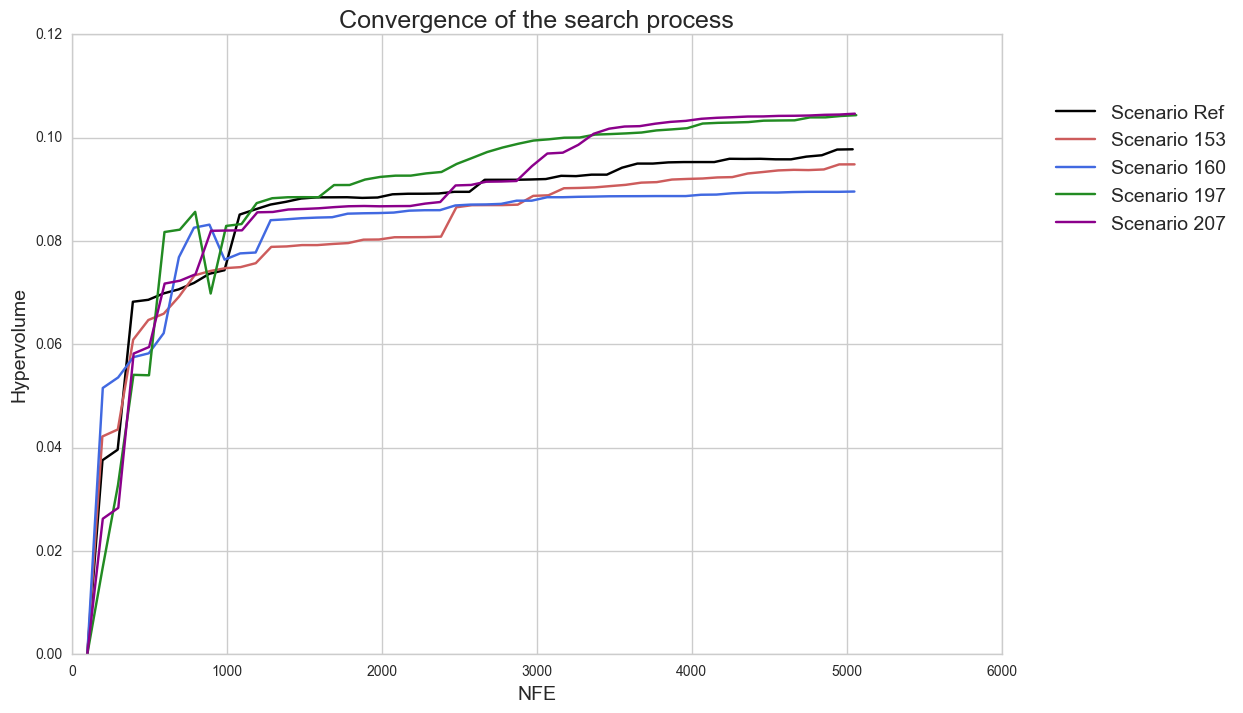

In [33]:
plot_convergence(scenarios, 7)

### Brush the candidate solutions based on reliability

In [64]:
for s in scenarios:
    for i, row_dec in decisions[s].iterrows():
        #if objectives[s].ix(i, 'reliability') <= 0.8:
        decisions[s] = decisions[s][objectives[s]['reliability'] >= 0.85]
        objectives[s] = objectives[s][objectives[s]['reliability'] >= 0.85]

In [65]:
#for randomly selected ones
for s in random_selected:
    for i, row_dec in decisions_r[s].iterrows():
        #if objectives[s].ix(i, 'reliability') <= 0.8:
        decisions_r[s] = decisions_r[s][objectives_r[s]['reliability'] >= 0.85]
        objectives_r[s] = objectives_r[s][objectives_r[s]['reliability'] >= 0.85]
    print(s, objectives_r[s].shape)
    decisions_r[s].to_csv("brushed_random_selected_sc{}.csv".format(s))

317 (22, 4)
208 (16, 4)
22 (11, 4)
304 (9, 4)


In [66]:
for s in scenarios:
    print(s, objectives[s].shape)

Ref (11, 4)
153 (12, 4)
160 (8, 4)
197 (18, 4)
207 (16, 4)


In [15]:
soln_trd = {}
for s in scenarios:
    soln_trd[s] = decisions[s].join(objectives[s])
for s in random_selected:
    soln_trd[s] = decisions_r[s].join(objectives_r[s])
soln_trd['Ref'].head()

c1        c2        r1        r2        w1   inertia     max_P  \
5   0.603692  0.999510  1.760778  1.169727  0.965963  0.010101  0.184761   
25  0.196860  0.783298  1.284615  1.695729  0.829402  0.000000  0.098277   
40  0.343720 -0.379184  0.438344  1.637462  0.653934  0.021414  0.411720   
51  0.245043 -0.681731  1.411823  1.848867  0.753100  0.000101  0.312032   
57  0.268973 -0.664270  1.551074  1.757820  0.786333  0.000000  0.161250   

    reliability   utility  
5        1.0000  0.465724  
25       1.0000  0.210962  
40       0.9615  0.551405  
51       0.9987  0.403607  
57       1.0000  0.359167

In [25]:
#plot_optimal_for_selected, but with ANNOTATION
import seaborn as sns
sns.set_style("whitegrid")

def plot_optimal_annotation(data, scenarios, labels, title, fn, lw=0.7):
    df_minima = pd.DataFrame([np.min(data[s], axis=0) for s in scenarios])
    df_maxima = pd.DataFrame([np.max(data[s], axis=0) for s in scenarios])
    minima = np.min(df_minima, axis=0)
    maxima = np.max(df_maxima, axis=0)
    #print(maxima)
    axes = setup_parallel_plot(labels, maxima, minima, labels)

    normed_data = {}
    for key in scenarios:
        normed_data[key] = normalize(data[key], minima, maxima)
        #normed_data[key] = normed_data[key].sort_index(axis=1) #re-ordering the columns of the df to align the grid with the df
        normed_data[key] = normed_data[key][labels]
    fig = plt.gcf()

    #clrs = ['black']+colors #, 'indianred', 'royalblue', 'forestgreen', 'darkmagenta']
    clrs=['black']+colors+sns.color_palette("Paired", 4)
    plabels = []
    some_identifiers = []
    
    for j in range(len(labels)-1): #df_outcomes.shape[1]-1
        ax = axes[j]
        for i, key in enumerate(scenarios):
            y = normed_data[key].ix[:, j:j+2]  
            x = np.tile([j+1,j+2], (y.shape[0], 1))
            ax.plot(x.T, y.T, color=clrs[i], linewidth=lw)
            #plot lines below the axes
            if j < 4:
                ax.axhline(y=-0.32,xmin=0,xmax=1,c="black",linewidth=1,zorder=0, clip_on=False)
            elif j > 4:
                ax.axhline(y=-0.32,xmin=0,xmax=1,c="black",linewidth=1,zorder=0, clip_on=False)
            #for legend
            if j == 0:
                plabels.append("Scenario {}".format(key))
                artist = plt.Rectangle((0,0), 1,1, edgecolor=clrs[i], facecolor=clrs[i])
                some_identifiers.append(artist)
        
    
    plt.legend(some_identifiers, plabels, loc=2, bbox_to_anchor=(1.05, 0.9), borderaxespad=0., fontsize=13)
    plt.text(2.3, -0.37, "Decision levers", fontsize=13)
    plt.text(7, -0.37, "Maximum regret", fontsize=13)    
    
    change_fontsize(fig, 14)
    fig.suptitle(title, fontsize=16)
    save_fig(fig, dir = './figs/mordm', name=fn)
    plt.show() 



C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


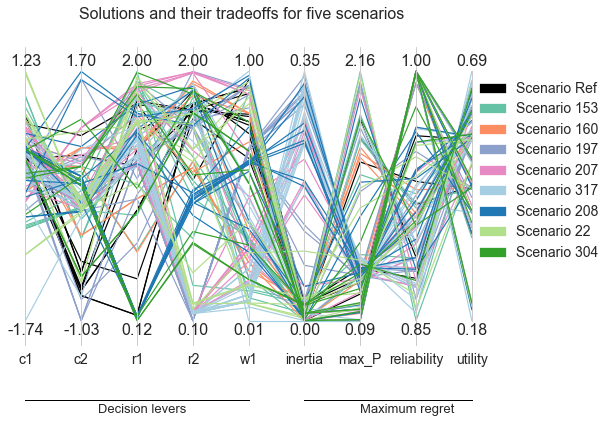

In [26]:
import numpy as np
import matplotlib.pyplot as plt
labels = levers + oois
title = "Solutions and their tradeoffs for five scenarios"
#fn = "Solutions_and_tradeoffs_cubic_brushed_v2.png"
fn = "Rnadomly_selected_comparison.png"
#for s in scenarios:
plot_optimal_annotation(soln_trd, scenarios+random_selected, labels, title, fn, lw=1.2)

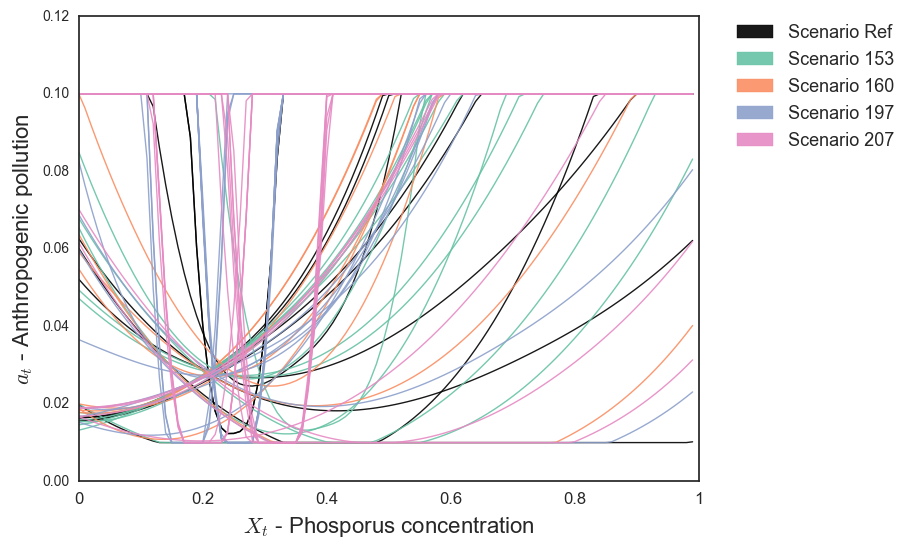

In [41]:
#PLOT A_T FOR ALL 'DECISIONS, COLORED BY SCENARIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
colors = ['black']+colors #, 'indianred', 'royalblue', 'forestgreen', 'darkmagenta']
fig = plt.figure(figsize=(8,6))
sns.set_style("white")
ax = fig.add_subplot(111)


x_s= np.arange(0, 1, 0.01)
labels = []
some_identifiers = []
for i,s in enumerate(scenarios):
    c = colors[i]
    for j, row in decisions[s].iterrows():
        y = [a_t(x, c=[row['c1'], row['c2']], r=[row['r1'], row['r2']], w=[row['w1'], 1-row['w1']]) for x in x_s]
        ax.plot(y, color=c, linewidth=1, alpha=0.9)
    labels.append("Scenario {}".format(s))
    artist = plt.Rectangle((0,0), 1,1, edgecolor=c, facecolor=c, alpha=0.9)
    some_identifiers.append(artist)

ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=12)
ax.set_xlabel("$X_t$ - Phosporus concentration", fontsize=16)
ax.set_ylabel("$a_t$ - Anthropogenic pollution", fontsize=16)                     
plt.legend(some_identifiers, labels, loc=2, bbox_to_anchor=(1.05, 1), borderaxespad=0., fontsize=13)
directory = 'D:/sibeleker/surfdrive/Documents/Notebooks/Lake_model-MORDM/Sibel/figs/mordm/'
plt.savefig('./figs/mordm/solutions_fnc_brushed_v2.png', dpi=600, bbox_inches='tight')

plt.show()
        


In [114]:
#plotting all on a parallel plot with different colors

def plot_optimal_for_selected(data, scenarios, labels, title, fn, colors):
    df_minima = pd.DataFrame([np.min(data[s], axis=0) for s in scenarios])
    df_maxima = pd.DataFrame([np.max(data[s], axis=0) for s in scenarios])
    minima = np.min(df_minima, axis=0)
    maxima = np.max(df_maxima, axis=0)
    #print(maxima)
    axes = setup_parallel_plot(labels, maxima, minima, labels)

    normed_data = {}
    for key in scenarios:
        normed_data[key] = normalize(data[key], minima, maxima)
        normed_data[key] = normed_data[key].sort_index(axis=1) #re-ordering the columns of the df to align the grid with the df

    fig = plt.gcf()

    #colors = ['black', 'indianred', 'royalblue', 'forestgreen', 'darkmagenta']
    plabels = []
    some_identifiers = []
    
    for j in range(len(labels)-1): #df_outcomes.shape[1]-1
        ax = axes[j]
        for i, key in enumerate(scenarios):
            y = normed_data[key].ix[:, j:j+2]  
            x = np.tile([j+1,j+2], (y.shape[0], 1))
            ax.plot(x.T, y.T, color=colors[i], linewidth=1.5)
            #for legend
            if j == 0:
                plabels.append("{}".format(key))
                artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[i], facecolor=colors[i])
                some_identifiers.append(artist)
        
    
    plt.legend(some_identifiers, plabels, loc=2, bbox_to_anchor=(1.05, 0.9), borderaxespad=0., fontsize=13)

    change_fontsize(fig, 14)
    fig.suptitle(title, fontsize=18)
    save_fig(fig, dir = './figs/mordm', name=fn)
    plt.show()  

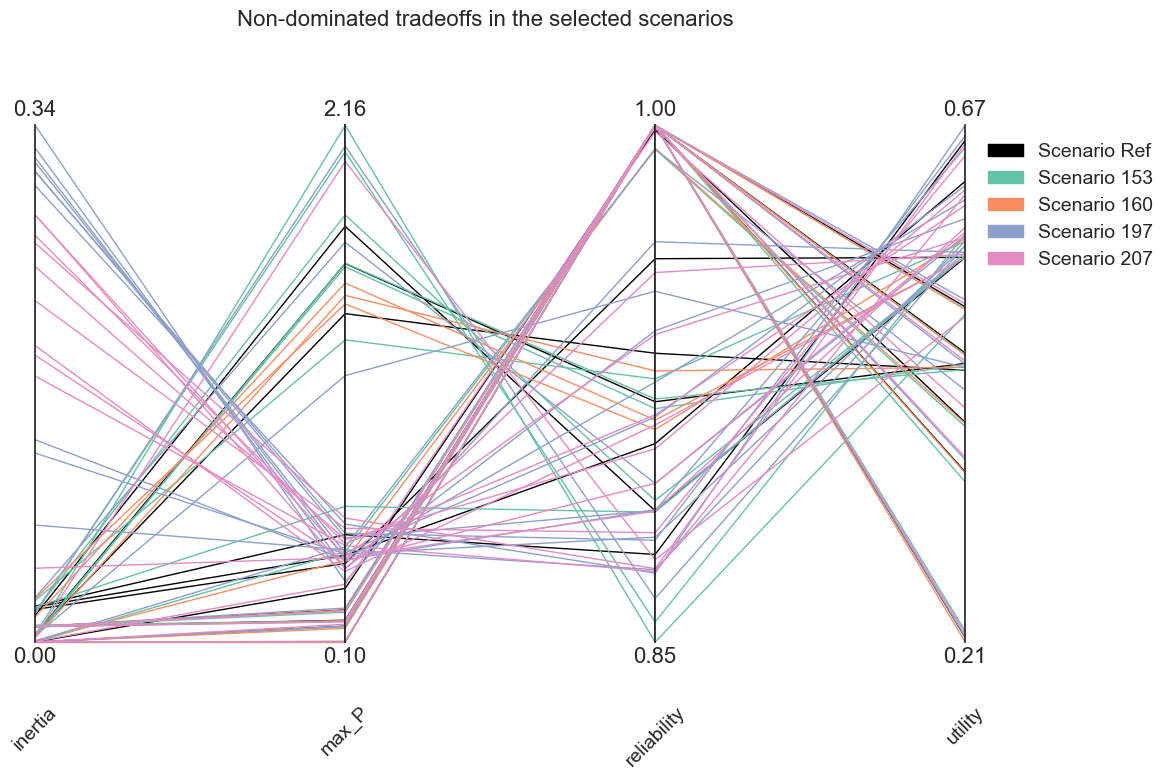

In [48]:
import numpy as np
title = "Non-dominated tradeoffs in the selected scenarios"
plot_optimal_for_selected(objectives, scenarios, oois, title, "Solutions_eps_v7_v2.png")

In [105]:
all_decisions = pd.concat([decisions[s] for s in scenarios[1:]],ignore_index=True)
all_decisions_r = pd.concat([decisions_r[s] for s in random_selected],ignore_index=True)
data = {'diverse' : all_decisions,
        'random' : all_decisions_r}

C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


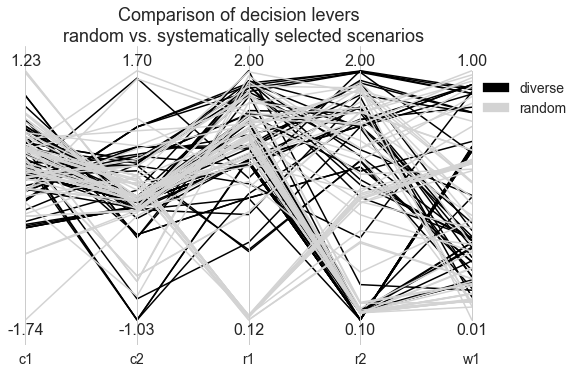

In [116]:
title="Comparison of decision levers \n random vs. systematically selected scenarios"
plot_optimal_for_selected(data, ['diverse', 'random'], levers, title, "Decisions_random.png", ['black', 'lightgrey'])

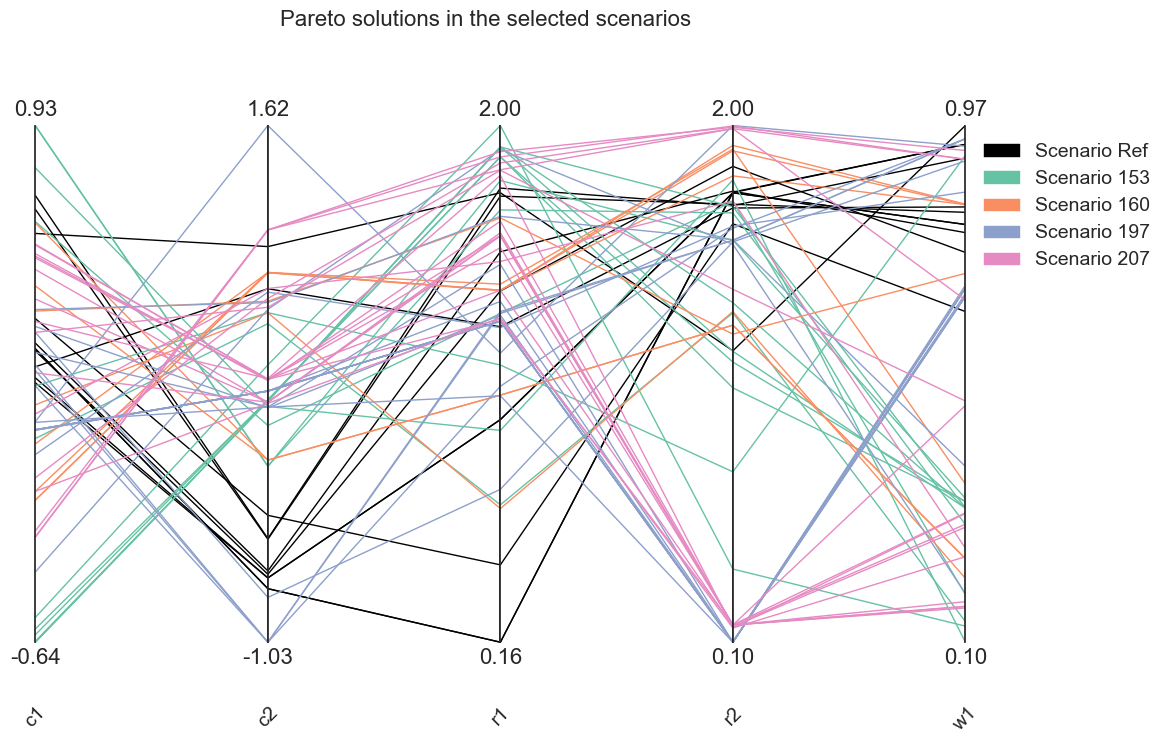

In [49]:
title="Pareto solutions in the selected scenarios"
plot_optimal_for_selected(decisions, scenarios, levers, title, "Decisions_eps_v7_v2.png")

### comparison based on kde's

In [52]:
import matplotlib.gridspec as gridspec
import seaborn as sns
def make_grid_den(oois):
    grid = gridspec.GridSpec(2, 2) 
    grid.update(wspace = 0.2,
                hspace = 0.3)
    
    figure = plt.figure()
    figure.set_figheight(9)
    figure.set_figwidth(12)

    axes = {}
    axes[oois[0]] = figure.add_subplot(grid[0,0])
    axes[oois[1]] = figure.add_subplot(grid[0,1])
    axes[oois[2]] = figure.add_subplot(grid[1,0])
    axes[oois[3]] = figure.add_subplot(grid[1,1])
    
    
    for ooi in oois:
        axes[ooi].set_title(ooi, size=14)

    
    return figure, axes


def plot_kdes_forselected(objectives, scenarios, oois, fn, title):
    
    fig, axes = make_grid_den(oois)
    colors = ['grey', 'indianred', 'royalblue', 'forestgreen', 'darkmagenta']
    labels = []
    some_identifiers = []
    for ooi in oois:
        for i, key in enumerate(scenarios):
            data = objectives[key][ooi]
            sns.kdeplot(data, ax=axes[ooi], legend=False, color=colors[i])
            if ooi == 'inertia': #to have them only once
                labels.append("Scenario {}".format(key))
                artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[i], facecolor=colors[i], alpha=0.7)
                some_identifiers.append(artist)      
    
    plt.legend(some_identifiers, labels, loc=2, bbox_to_anchor=(1.05, 1.4), borderaxespad=0., fontsize=13)
    
    fig.suptitle(title, fontsize=14)
    #fig.subplots_adjust(right=0.75)
    save_fig(fig, dir = './figs/mordm', name="{}.png".format(title))
    plt.show()
        


## Step 4: Explore the robustness of candidates generated under each scenario

Watson&Kaspyrzyk look at the performance of candidate solutions resulting from a selected scenario under other selected scenarios.

Below, I look at at the performance of candidate solutions resulting from a selected scenario under all scenarios that I initially generated.


### Generate 1000 scenarios for each candidate solution

In [10]:
from ema_workbench import Policy
#65 SOLUTIONS
policies = []
    
for s in scenarios:
    solutions = decisions[s]
    for index, row in solutions.iterrows():
        name = str(s)+'_'+str(index)
        decision = {lever.name:row[lever.name] for lever in lake_model.levers} #levers are in the first columns of the solutions
        policies.append(Policy(name=name, **decision))

Since 65 candidate solutions and 1000 scenarios for each require 65000 runs, we use multiprocesssing. See **CandidateTesting.py**. Optionally, ipyparallel could be used.

### Visualize the density distribution of scenario sets for each candidate solution

In [30]:
from ema_workbench import load_results
results = load_results(r'./data/CandidateTesting_v7_1000scenarios_65cands.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from H:\MyDocuments\Notebooks\Lake_model-MORDM\Sibel\MORDM_paper\data\CandidateTesting_v7_1000scenarios_65cands.tar.gz


In [31]:
results_r = load_results(r'./data/CandidateTesting_random_1000scenarios_58cands.tar.gz')
experiments_r, outcomes_r = results_r

[MainProcess/INFO] results loaded succesfully from H:\MyDocuments\Notebooks\Lake_model-MORDM\Sibel\MORDM_paper\data\CandidateTesting_random_1000scenarios_58cands.tar.gz


C:\Users\sibeleker.DASTUD\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


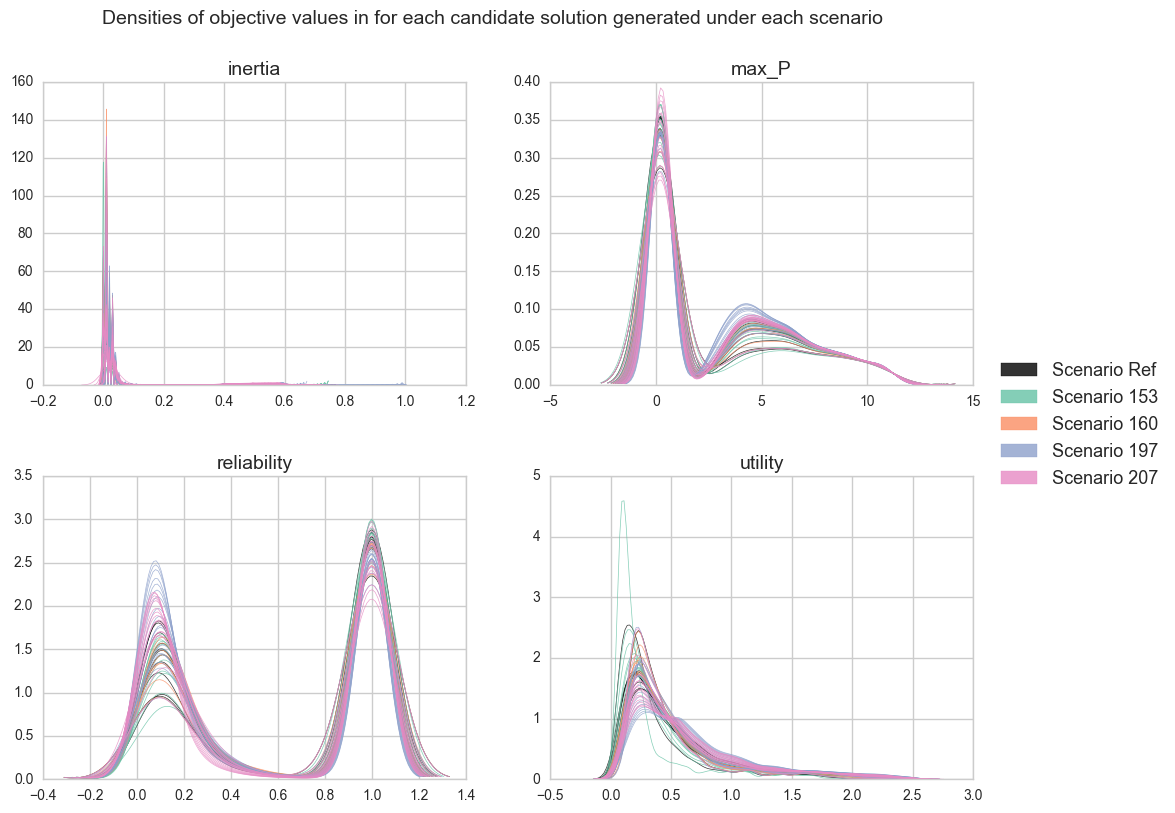

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
fig, axes = make_grid_den(oois)
labels = []
some_identifiers = []   
#colors = ['black', 'indianred', 'royalblue', 'forestgreen', 'darkmagenta']

for ooi in oois:
    for i, s in enumerate(scenarios):
        indices = np.array([p_name.startswith(str(s)) for p_name in experiments['policy']])
        scenario_outcomes = outcomes[ooi][indices]
        no_sol = int(len(scenario_outcomes)/1000)
        for sol in range(no_sol):
            end = 1000*(sol+1)
            data = scenario_outcomes[sol:end]
            sns.kdeplot(data, ax=axes[ooi], color=colors[i], linewidth=0.5, alpha=0.8)
        if ooi == 'inertia': #to have them only once
            labels.append("Scenario {}".format(s))
            artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[i], facecolor=colors[i], alpha=0.8)
            some_identifiers.append(artist)
    
plt.legend(some_identifiers, labels, loc=2, bbox_to_anchor=(1.05, 1.4), borderaxespad=0., fontsize=13)

fig.suptitle("Densities of objective values in for each candidate solution generated under each scenario", fontsize=14)
#save_fig(fig, dir = './figs/mordm', name="Densities_scenario_solns_v6.png")
plt.savefig('./figs/mordm/Densities_scenario_solns_v6_v2.png', dpi=300, b_box_inches='tight')
plt.show()

In this figure, each line depicts the density distribution of 1000 scenarios in the case of implementing one of the candidate solutions generated under the scenario corresponding to its color. 


Litle variation in inertia results in very high densities around some values, hence the peaks.

Overall, solutions found under different scenarios do not significantly shift the scenario space. However, they change the distributional characteristics of it. Therefore, I expect to see some differences in robustness performance.

### Robustness: Signal to Noise Ratio

In [34]:
def calculate_signalNoise(data, obj):
    
    if obj == -1: #MINIMIZE
        score = (np.nanmean(data)+1)*(np.nanstd(data)+1)
    elif obj == 1: #MAXIMIZE
        score = (np.nanmean(data)+1)/(np.nanstd(data)+1)
    return score

In [32]:
#[outcome.kind for outcome in outcomes]
ooi_obj ={ooi.name: ooi.kind for ooi in lake_model.outcomes}
print(ooi_obj)

{'max_P': -1, 'utility': 1, 'inertia': -1, 'reliability': 1}


In [35]:
# decisions is a dictionary {scenario:df of lever values}
# I copy this to a new 'results' df, then fill the df with robustness values for each ooi 
sigN_results = {}
for scenario, value in decisions.items():
    sigN_results[scenario] = value.copy()
for scenario, value in decisions_r.items():
    sigN_results[scenario] = value.copy() 


for ooi, obj in ooi_obj.items():
    for i, s in enumerate(scenarios):
#         indices = np.array([p_name.startswith(str(s)) for p_name in experiments['policy']])
#         scenario_outcomes = outcomes[ooi][indices]
        for sol in sigN_results[s].index:
            data = outcomes[ooi][experiments['policy'] == str(s)+'_'+str(sol)]
            rob = calculate_signalNoise(data, obj)
            #print(s, sol, ooi, rob)
            sigN_results[s].set_value(sol, ooi, rob)
            
    for i, s in enumerate(random_selected):
        for sol in sigN_results[s].index:
            data = outcomes_r[ooi][experiments_r['policy'] == str(s)+'_'+str(sol)]
            rob = calculate_signalNoise(data, obj)
            #print(s, sol, ooi, rob)
            sigN_results[s].set_value(sol, ooi, rob)


In [37]:
sigN_results[22]

c1        c2        r1        r2        w1      max_P   utility  \
16   0.422855  1.043493  1.597103  1.310766  0.896178  16.729628  1.106912   
27   0.657976  0.293688  1.612542  1.677265  0.957981  15.330159  1.069943   
52   0.416622 -0.608648  1.917548  1.405262  0.869487  19.505643  1.066140   
53   0.416622 -0.608648  1.960582  1.405262  0.937453  16.429857  0.968444   
64  -0.952629  0.173393  1.633274  1.598743  0.076424  19.485809  1.065786   
67   1.228786  0.173616  1.629669  0.223374  0.078487  20.086439  1.179165   
69   0.713580  0.187549  1.164538  0.461573  0.405196  18.759579  1.167947   
71   1.205132  0.209578  1.846160  0.230541  0.152625  19.539773  1.172279   
73  -0.952629  0.144493  1.634434  1.359051  0.077115  19.540556  1.068575   
81   1.205132  0.201537  1.845872  0.223374  0.148963  19.745324  1.176881   
100  0.724116  0.313062  1.636884  0.183918  0.278022  17.319401  1.190052   

      inertia  reliability  
16   1.027575     1.155266  
27   1.030765     1.204762  
52   1.009729     1.093082  
53   1.013816     1.215893  
64   1.010721     1.094483  
67   1.040349     0.970047  
69   1.040893     1.064488  
71   1.047066     1.010614  
73   1.010882     1.089328  
81   1.044126     0.998825  
100  1.572053     1.092224

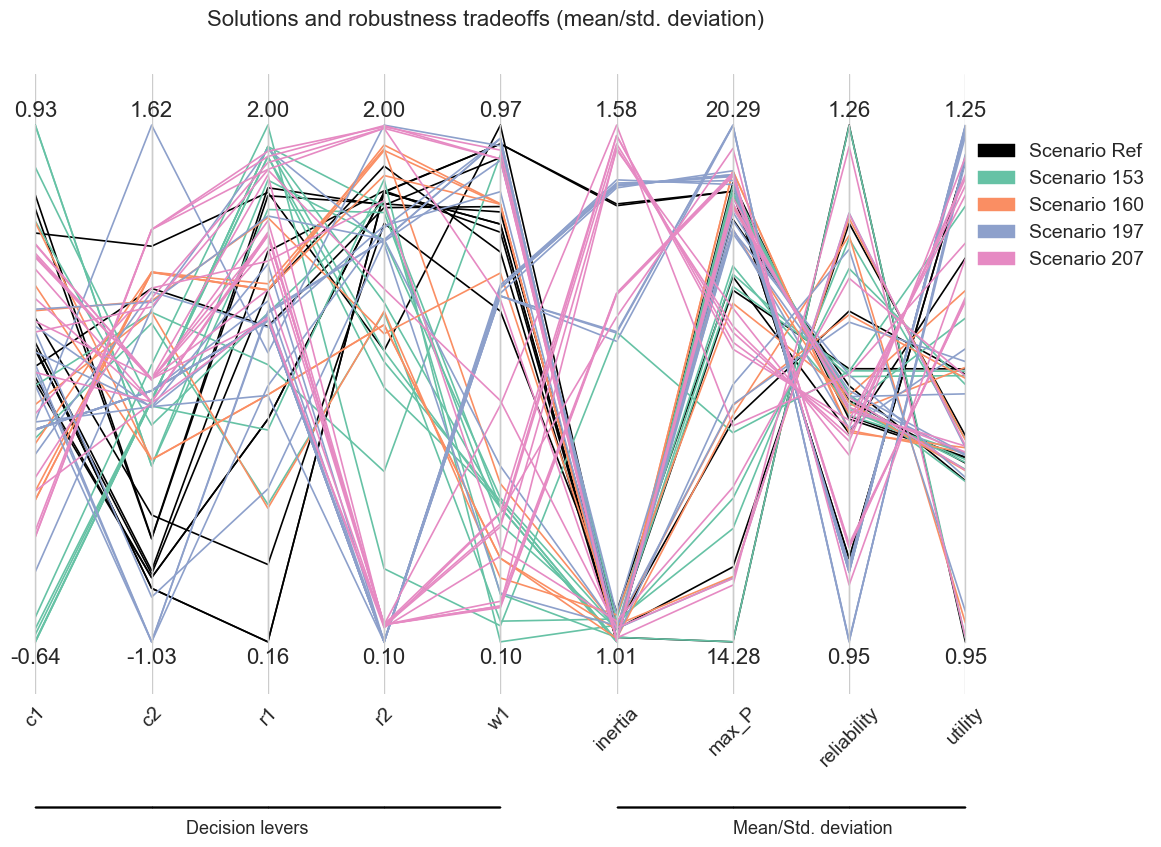

In [62]:
labels = levers + sorted(oois)
title = "Solutions and robustness tradeoffs (mean/std. deviation)"
fn = "SigN_parallel_plot_v7_v2.png"

plot_optimal_annotation(sigN_results, scenarios, labels, title, fn, lw=1.2)

In [36]:
colors = ['black']+colors

In [74]:
# get all the sig_noise results of diverse scenarios
# eliminate the dominated ones
# get all the sig_noise results of random scenarios
# eliminate the dominated ones
# compare the two sets
frames = [sigN_results[s] for s in [153, 160, 197, 207]] #excluding the reference scenario
sign_diverse = pd.concat(frames, ignore_index=True)
    

In [75]:
print(sigN_results.keys())

dict_keys(['Ref', 153, 160, 197, 207, 317, 208, 22, 304])


In [76]:
sign_diverse.shape

(54, 9)

In [79]:
count = 0
for index1, row in sign_diverse.iterrows():
    sol1 = row[oois]
    nondominated = True
    for index2, row in sign_diverse.iterrows():
        sol2 = row[oois]
        if index1 != index2:
            cond1 = np.all([sol2[ooi]>=sol1[ooi] for ooi in ['reliability', 'utility']])
            cond2 = np.all([sol2[ooi]<=sol1[ooi] for ooi in ['max_P', 'inertia']])
            if cond1 and cond2:
                nondominated=False
                break
    if not nondominated:
        sign_diverse.drop(index1, inplace=True)
        print("Sol {} is dominated.".format(index1))

Sol 4 is dominated.
Sol 16 is dominated.
Sol 18 is dominated.
Sol 19 is dominated.
Sol 21 is dominated.
Sol 29 is dominated.
Sol 40 is dominated.
Sol 44 is dominated.
Sol 47 is dominated.
Sol 49 is dominated.
Sol 53 is dominated.


In [81]:
frames = [sigN_results[s] for s in random_selected] #excluding the reference scenario
sign_random = pd.concat(frames, ignore_index=True)
print(sign_random.shape)
for index1, row in sign_random.iterrows():
    sol1 = row[oois]
    nondominated = True
    for index2, row in sign_diverse.iterrows():
        sol2 = row[oois]
        if index1 != index2:
            cond1 = np.all([sol2[ooi]>=sol1[ooi] for ooi in ['reliability', 'utility']])
            cond2 = np.all([sol2[ooi]<=sol1[ooi] for ooi in ['max_P', 'inertia']])
            if cond1 and cond2:
                nondominated=False
                break
    if not nondominated:
        sign_random.drop(index1, inplace=True)
        print("Sol {} is dominated.".format(index1))


(58, 9)
Sol 0 is dominated.
Sol 12 is dominated.
Sol 25 is dominated.
Sol 30 is dominated.
Sol 48 is dominated.
Sol 51 is dominated.
Sol 55 is dominated.
Sol 56 is dominated.
Sol 57 is dominated.


C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


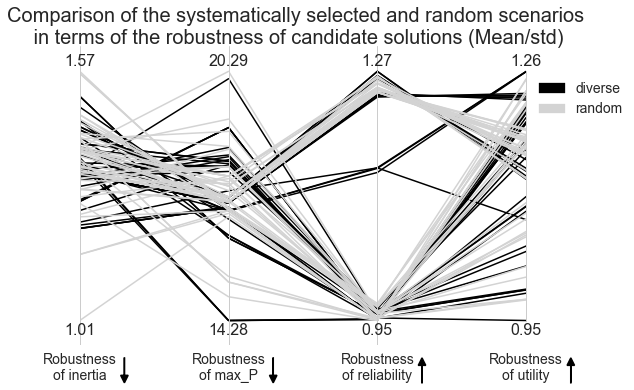

In [117]:
data = {'diverse':sign_diverse,
        'random' : sign_random}
plot_robustness(data, ['diverse', 'random'], sorted(oois), 
                "Comparison of the systematically selected and random scenarios\n in terms of the robustness of candidate solutions (Mean/std)",
                "Random_sign.png", ['black', 'lightgrey'])

In [103]:
##### PLOT MEAN/STD RESULTS WITH NEW LABELING AND ANNOTATION ####

sns.set_style("whitegrid")

def plot_robustness(data, scenarios, labels, title, fn, colors):
    df_minima = pd.DataFrame([np.min(data[s], axis=0) for s in scenarios])
    df_maxima = pd.DataFrame([np.max(data[s], axis=0) for s in scenarios])
    minima = np.min(df_minima, axis=0)
    maxima = np.max(df_maxima, axis=0)
    #print(maxima)
    new_labels=[]
    for ooi in labels:
        new_labels.append("Robustness\nof {}".format(ooi))
    axes = setup_parallel_plot(labels, maxima, minima, new_labels)
    # put vertical arrows near the labels here!!!
    for j, label in enumerate(labels): 
        x_arrow = j+1.3
        if j < len(labels)-1:
            ax = axes[j]
        else:
            ax = axes[j-1]
        #if label in ['inertia', 'max_P']: #MIN
        #    ax.arrow(x_arrow,-.15,0.,-0.1,fc='black',ec='black', lw=1.5, clip_on=False, length_includes_head=True,
        #            head_length=0.03, head_width=0.05)
        #else: #MAX
        #    ax.arrow(x_arrow,-.25,0., 0.1,fc='black',ec='black', lw=1.5, clip_on=False, length_includes_head=True,
        #            head_length=0.03, head_width=0.05)
        ax.arrow(x_arrow,-.15,0.,-0.1,fc='black',ec='black', lw=1.5, clip_on=False, length_includes_head=True, 
                 head_length=0.03, head_width=0.05)
    

    normed_data = {}
    for key in scenarios:
        normed_data[key] = normalize(data[key], minima, maxima)
        normed_data[key] = normed_data[key].sort_index(axis=1) #re-ordering the columns of the df to align the grid with the df

    fig = plt.gcf()

    #colors = ['black', 'indianred', 'royalblue', 'forestgreen', 'darkmagenta']
    #colors = colors + 4*['lightgrey']
    plabels = []
    some_identifiers = []
    
    for j in range(len(labels)-1): #df_outcomes.shape[1]-1
        ax = axes[j]        
        for i, key in enumerate(scenarios):
            y = normed_data[key].ix[:, j:j+2]  
            x = np.tile([j+1,j+2], (y.shape[0], 1))
            ax.plot(x.T, y.T, color=colors[i], linewidth=1.5)
            
            #for legend
            if j == 0:
                plabels.append("{}".format(key))
                artist = plt.Rectangle((0,0), 1,1, edgecolor=colors[i], facecolor=colors[i])
                some_identifiers.append(artist)
        
    
    plt.legend(some_identifiers, plabels, loc=2, bbox_to_anchor=(1.05, 0.9), borderaxespad=0., fontsize=13)

    change_fontsize(fig, 14)
    fig.suptitle(title, fontsize=20)
    save_fig(fig, dir = './figs/mordm', name=fn)
    plt.show() 


C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


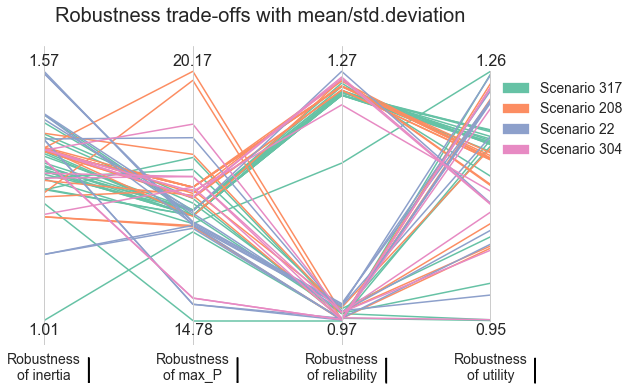

In [54]:
clrs=4*['lightgrey']+['black']+colors
plot_robustness(sigN_results, random_selected, sorted(oois), "Robustness trade-offs with mean/std.deviation", "Random_comparison.png", colors)

Candidate solutions generated under different scenarios indeed result in different robustness values.
However, there are no very distinc trends observed between scenarios.

For max_P and inertia, the lower the signal to noise value, the better.
For other objectives, higher values are favored.

For instance, by searching under scenario 160 and 197, we obtained more robust solutions for *max_P* and *reliability* than the solutions we obtained under the reference scenario. 

### Robustness: Maximum regret

In [49]:
def calculate_maxregret(data, obj, n_sol):
    data = np.array(data)
    if obj == 1: #MAXIMIZE 
        zero_regrets = np.max(data, axis=0)
    elif obj == -1: #MINIMIZE
        zero_regrets = np.min(data, axis=0)
    regrets = [abs(np.subtract(data[p], zero_regrets)) for p in range(n_sol)]
    max_regrets = np.max(regrets, axis=1)
    return max_regrets


In [50]:
reg_results = {}
for scenario, value in decisions.items():
    reg_results[scenario] = value.copy()   
for scenario, value in decisions_r.items():
    reg_results[scenario] = value.copy()   
    
for ooi, obj in ooi_obj.items():
    for i, s in enumerate(scenarios):
        #indices = np.array([p_name.startswith(str(s)) for p_name in experimentsC['policy']])
        #scenario_outcomes = outcomesC[ooi][indices]
        #no_sol = int(len(scenario_outcomes)/1000)
        data = []
        for sol in reg_results[s].index:
            data_p = outcomes[ooi][experiments['policy'] == str(s)+'_'+str(sol)]
            data.append(data_p)
        rob = calculate_maxregret(data, obj, len(reg_results[s].index))
        for i,sol in enumerate(reg_results[s].index):
            reg_results[s].set_value(sol, ooi, rob[i])
    
    for i, s in enumerate(random_selected):
        data = []
        for sol in reg_results[s].index:
            data_p = outcomes_r[ooi][experiments_r['policy'] == str(s)+'_'+str(sol)]
            data.append(data_p)
        rob = calculate_maxregret(data, obj, len(reg_results[s].index))
        for i,sol in enumerate(reg_results[s].index):
            reg_results[s].set_value(sol, ooi, rob[i])

In [84]:
frames = [reg_results[s] for s in [153, 160, 197, 207]] #excluding the reference scenario
reg_diverse = pd.concat(frames, ignore_index=True)
for index1, row in reg_diverse.iterrows():
    sol1 = row[oois]
    nondominated = True
    for index2, row in sign_diverse.iterrows():
        sol2 = row[oois]
        if index1 != index2:
            cond1 = np.all([sol2[ooi]<=sol1[ooi] for ooi in oois])
            if cond1:
                nondominated=False
                break
    if not nondominated:
        reg_diverse.drop(index1, inplace=True)
        print("Sol {} is dominated.".format(index1))

In [85]:
frames = [reg_results[s] for s in random_selected] #excluding the reference scenario
reg_random = pd.concat(frames, ignore_index=True)
for index1, row in reg_random.iterrows():
    sol1 = row[oois]
    nondominated = True
    for index2, row in sign_diverse.iterrows():
        sol2 = row[oois]
        if index1 != index2:
            cond1 = np.all([sol2[ooi]<=sol1[ooi] for ooi in oois])
            if cond1:
                nondominated=False
                break
    if not nondominated:
        reg_random.drop(index1, inplace=True)
        print("Sol {} is dominated.".format(index1))

C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


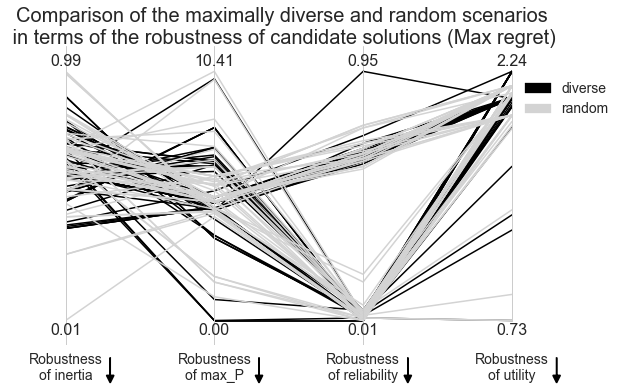

In [102]:
data = {'diverse':reg_diverse,
        'random' : reg_random}
plot_robustness(data, ['diverse', 'random'], sorted(oois), 
                "Comparison of the systematically selected and random scenarios\n in terms of the robustness of candidate solutions (Max regret)",
                "Random_regret.png", ['black', 'lightgrey'])

In [51]:
reg_results[22]

c1        c2        r1        r2        w1     max_P   utility  \
16   0.422855  1.043493  1.597103  1.310766  0.896178  9.502953  1.836009   
27   0.657976  0.293688  1.612542  1.677265  0.957981  4.628253  2.150580   
52   0.416622 -0.608648  1.917548  1.405262  0.869487  9.511055  1.749695   
53   0.416622 -0.608648  1.960582  1.405262  0.937453  9.407674  2.127535   
64  -0.952629  0.173393  1.633274  1.598743  0.076424  9.510911  1.734210   
67   1.228786  0.173616  1.629669  0.223374  0.078487  9.513981  0.946823   
69   0.713580  0.187549  1.164538  0.461573  0.405196  9.513443  1.679954   
71   1.205132  0.209578  1.846160  0.230541  0.152625  9.514004  1.783371   
73  -0.952629  0.144493  1.634434  1.359051  0.077115  9.511175  1.721316   
81   1.205132  0.201537  1.845872  0.223374  0.148963  9.514003  1.775987   
100  0.724116  0.313062  1.636884  0.183918  0.278022  9.514018  1.893424   

      inertia  reliability  
16   0.040404         0.87  
27   0.050505         0.79  
52   0.010101         0.84  
53   0.020202         0.70  
64   0.010101         0.84  
67   0.070707         0.93  
69   0.050505         0.92  
71   0.191919         0.94  
73   0.010101         0.84  
81   0.161616         0.93  
100  0.767677         0.95

C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


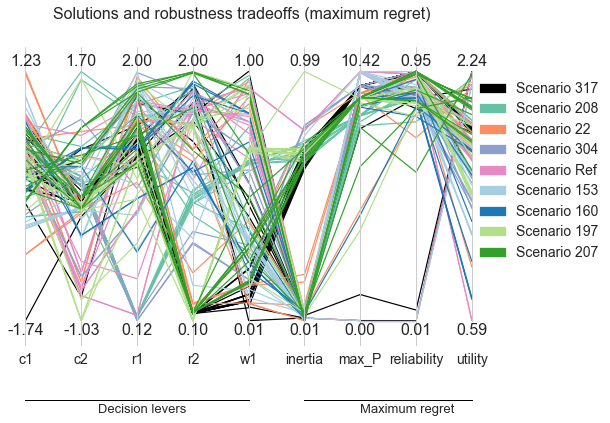

In [52]:
title = "Solutions and robustness tradeoffs (maximum regret)"
#fn = "Regret_parallel_plot_v7_v2.png"
fn = "Regret_random_selected"
plot_optimal_annotation(reg_results, random_selected+scenarios, labels, title, fn, lw=1.2)

C:\Users\eker\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


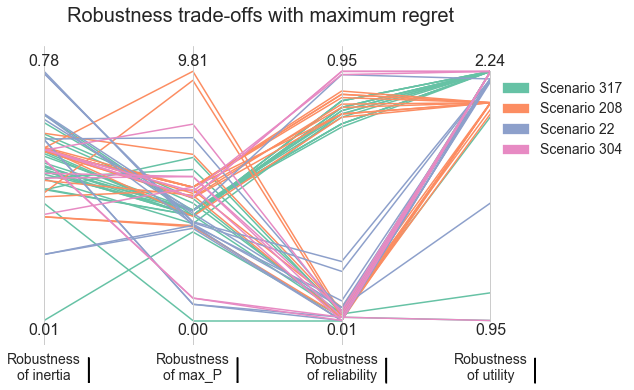

In [55]:
plot_robustness(reg_results, random_selected, sorted(oois), "Robustness trade-offs with maximum regret", "Regret_randomselected.png", colors)

The lower the maximum regret values of a solution, the better it is, regardless of the objective. 

The differences between candidate solutions generated under different scenarios can be more clealy observed with this robustness metric. Again, it is apparent that sharp tradeoffs persist.

Different tradeoffs, e.g. Scenario 153 generates solutions that are good both for inertia and maximum pollution. 

### Robustness: Domain criterion:

max_p < 2
inertia < 0.05
utility > 2
relaibility > 0.85

In [81]:
dom_results = {}
for scenario, value in decisions.items():
    dom_results[scenario] = value.copy()   
    
thresholds = {'max_P' : 1,
              'inertia' : .05,
              'utility' : 2,
              'reliability' : 1}
for ooi, obj in ooi_obj.items():
    print(ooi, obj)
    for i, s in enumerate(scenarios):
        for sol in dom_results[s].index:
            data = outcomes[ooi][experiments['policy'] == str(s)+'_'+str(sol)]
            th_data = [d  for d in data if (d*obj) >= (thresholds[ooi]*obj)]
            rob = len(th_data)/len(data)
#             if ooi in ['reliability', 'max_P']:
#                 print(s, sol, ooi, rob)
#             #print(s, sol, ooi, rob)
            dom_results[s].set_value(sol, ooi, rob)

max_P -1
Ref 5 max_P 0.652
Ref 25 max_P 0.692
Ref 40 max_P 0.513
Ref 51 max_P 0.451
Ref 57 max_P 0.462
Ref 62 max_P 0.517
Ref 63 max_P 0.583
Ref 65 max_P 0.426
Ref 74 max_P 0.42
Ref 91 max_P 0.42
Ref 93 max_P 0.431
153 9 max_P 0.692
153 17 max_P 0.641
153 32 max_P 0.454
153 35 max_P 0.625
153 37 max_P 0.43
153 42 max_P 0.515
153 44 max_P 0.502
153 55 max_P 0.436
153 86 max_P 0.507
153 90 max_P 0.596
153 98 max_P 0.442
153 102 max_P 0.436
160 3 max_P 0.658
160 8 max_P 0.576
160 12 max_P 0.474
160 26 max_P 0.585
160 34 max_P 0.451
160 57 max_P 0.527
160 63 max_P 0.412
160 80 max_P 0.412
197 2 max_P 0.658
197 12 max_P 0.472
197 24 max_P 0.575
197 52 max_P 0.478
197 73 max_P 0.572
197 75 max_P 0.466
197 84 max_P 0.475
197 96 max_P 0.268
197 102 max_P 0.458
197 116 max_P 0.373
197 117 max_P 0.395
197 121 max_P 0.271
197 122 max_P 0.375
197 124 max_P 0.373
197 136 max_P 0.371
197 138 max_P 0.267
197 150 max_P 0.379
197 153 max_P 0.387
207 1 max_P 0.659
207 54 max_P 0.447
207 77 max_P 0.38
20

### Robustness: Mean and Kurtosis

In [55]:
def calculate_kurtosis(data_t, obj):
    numerator = np.percentile(data_t, 90)-np.percentile(data_t, 10)
    denominator = np.percentile(data_t, 75)-np.percentile(data_t, 25)
    if denominator == 0:
        kurtosis = 1
    else:
        kurtosis = numerator/denominator
    return kurtosis

In [116]:
kurt_results = {}
for scenario, value in decisions.items():
    kurt_results[scenario] = value.copy()

for ooi, obj in ooi_obj.items():
    for i, s in enumerate(scenarios):
        indices = np.array([p_name.startswith(str(s)) for p_name in experimentsC['policy']])
        scenario_outcomes = outcomesC[ooi][indices]
        no_sol = int(len(scenario_outcomes)/1000)
        for sol in range(no_sol):
            start = 1000*sol
            end = 1000*(sol+1)
            data = scenario_outcomes[start:end]
            rob = calculate_kurtosis(data, obj)
            kurt_results[s].set_value(sol, ooi, rob)
            kurt_results[s].set_value(sol, ooi+"_mean", np.mean(data))